## Imports and data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import re
import gc
from sklearn.feature_extraction.text import TfidfVectorizer as tfd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize.casual import TweetTokenizer
import lightgbm as lgb
import scipy
import nltk.tokenize
%matplotlib inline

In [2]:
with zipfile.ZipFile('nlp-getting-started.zip') as f:
    with f.open('train.csv') as dd:
        df = pd.read_csv(dd)

In [5]:
text = df['text']
text.apply(TweetTokenizer().tokenize)

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1        [Forest, fire, near, La, Ronge, Sask, ., Canada]
2       [All, residents, asked, to, ', shelter, in, pl...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1, ., 94, [, 01:04, UTC, ], ?, 5km, S, of, V...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest, :, More, Homes, Razed, by, North...
Name: text, Length: 7613, dtype: object

In [33]:
df[df['keyword'].notnull()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


## preprocessing text data

### 'location' preprocessing

In [34]:
df.dropna().tail()

,id,keyword,location,text,target
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [35]:
df['location'].value_counts()[:30].head()

USA              104
New York          71
United States     50
London            45
Canada            29
Name: location, dtype: int64

In [36]:
def find_codes(x):
    res = re.findall(r',\W([A-Z][A-Z][A-Z]?)', x)
    return res[0] if res != [] else np.nan
    
states = df['location'].dropna().apply(find_codes)
# UK replacement
uks = states.dropna().apply(lambda x: 'UK' in x)
uks_idx = uks[uks == True].index
df.loc[uks_idx, 'location']  = 'UK'

In [37]:
def compress_to_code(x):
    for code in states.value_counts().index:
        if code in x:
            return code
    return x

# state codes
idx = df['location'].dropna().index
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(compress_to_code)

# 'world' users
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(lambda x: 'world' if 'world' in x.lower() else x)

# england users
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(lambda x: 'UK' if 'england' in x.lower() else x)

# NY users
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(lambda x: 'USA' if 'new york' in x.lower() else x)
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(lambda x: 'USA' if 'ny' in x.lower() else x)

# London users
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(lambda x: 'UK' if 'london' in x.lower() else x)

# USA users
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(lambda x: 'USA' if 'united' in x.lower() else x)

# @ users
df.loc[idx, 'location'] = df.loc[idx, 'location'].apply(lambda x: '@' if '@' in x.lower() else x)

In [38]:
# group locations by their shortcuts
def group_shortcuts(locations, words):
    # recursilve function
    # stop when list of unique words is empty
    if words != []:
        # with start_word search for similar rows
        start_word = words[0]
        shorts = locations.apply(lambda x: start_word if start_word.lower() in x.lower() else np.nan)
        # pd.Series with not-null values to extract index
        shorts = shorts[shorts.notnull()]
        shorts = locations[shorts.index]
        # replace similar rows with minimal length word
        min_word = start_word
        for un_word in shorts.unique():
            words = words.tolist() if type(words) == np.ndarray else words
            min_word = un_word if len(un_word)<len(min_word) else min_word
            # reducing words's size
            try:
                words.remove(un_word)
            except:
                pass                
        locations[shorts.index] = min_word
        # recursive call
        group_shortcuts(locations, words)
    else:
        return locations

group_shortcuts(df['location'].dropna(), df['location'].dropna().unique())

C:\Users\egort\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [39]:
len(df['location'].dropna().unique())

2281

In [40]:
df['location'].value_counts()

USA                    627
UK                     240
CA                     156
world                   85
TX                      62
                      ... 
Punjab                   1
Where ever i please      1
Jaipur, India            1
italy                    1
toledo                   1
Name: location, Length: 2281, dtype: int64

In [41]:
# locations with frequency 10 and less are merged in single category
temp = df['location'].value_counts().apply(lambda x: x if x < 10 else np.nan)
low_freq_locs = temp.dropna().index
df['location'] = df['location'].apply(lambda x: 'unusual location' if x in low_freq_locs else x)
# ffill is a method which place last valid observation
df['location'] = df['location'].fillna(method='ffill')
df['location'] = df['location'].fillna('unusual location')
del temp
gc.collect()

150

### 'id' preprocessing

In [42]:
df['id'].value_counts().sort_values()

2047    1
4086    1
6133    1
8180    1
2031    1
       ..
4098    1
24      1
216     1
6163    1
2049    1
Name: id, Length: 7613, dtype: int64

In [43]:
# all ids unique so it's reasonable to drop them
df = df.drop(columns=['id'])

In [44]:
df['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

## Text preprocessing

In [45]:
# extract hashtags, mentioned and links
def demo_tknz(x):
    print(x['target'], nltk.tokenize.casual_tokenize(x['text']))
    
temp = df[30:35].apply(demo_tknz, axis=1)

0 ['The', 'end', '!']
1 ['@bbcmtd', 'Wholesale', 'Markets', 'ablaze', 'http://t.co/lHYXEOHY6C']
0 ['We', 'always', 'try', 'to', 'bring', 'the', 'heavy', '.', '#metal', '#RT', 'http://t.co/YAo1e0xngw']
1 ['#AFRICANBAZE', ':', 'Breaking', 'news', ':', 'Nigeria', 'flag', 'set', 'ablaze', 'in', 'Aba', '.', 'http://t.co/2nndBGwyEi']
0 ['Crying', 'out', 'for', 'more', '!', 'Set', 'me', 'ablaze']


In [46]:
# investigate how number of links in tweet related with target label 
n_links = df['text'].apply(lambda x: len(re.findall(r'http://\S*', x, re.IGNORECASE)))

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# def theils_u(x, y):
#     x_counter = Counter(x)
#     s_xy = conditional_entropy(x,y)
#     total_occurrences = sum(x_counter.values())
#     p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
#     s_x = ss.entropy(p_x)
#     if s_x == 0:
#         return 1
#     else:
#         return (s_x - s_xy) / s_x

print(cramers_v(n_links, df['target']))
# print(theils_u(n_links, df['target']))

0.27786300500052374


## stupid approach

In [72]:
def make_vectors(text_data):
    vectorizer = tfd(ngram_range=(1,3), min_df=5, max_df=500)
    text_vectorized = vectorizer.fit_transform(text_data)
    return vectorizer, text_vectorized

Wall time: 1.76 s


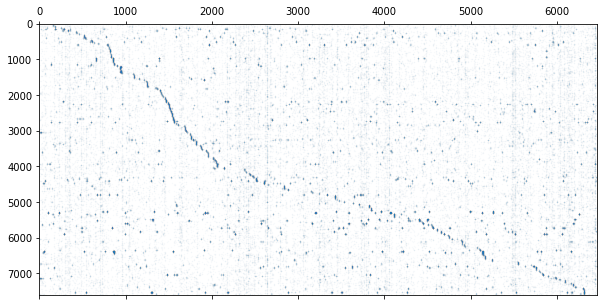

In [73]:
%%time
vectorizer, word_matrix = make_vectors(df['text'])
fig = plt.figure(figsize=(10,5)); ax = fig.add_subplot(111)
ax.spy(word_matrix, aspect='auto', markersize=0.004)

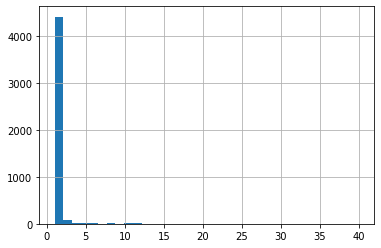

In [49]:
word_freqs = word_matrix.sum(axis=0)
word_freqs_hist = list(map(float, word_freqs.reshape(-1,1)))
word_freqs_hist = pd.Series(word_freqs_hist).value_counts().sort_values()
word_freqs_hist.hist(bins=35, label='Words frequencies histogram')

### check if vectorizer is up on new data

In [70]:
with zipfile.ZipFile('nlp-getting-started.zip') as zfile:
    with zfile.open('test.csv') as dd:
        test = pd.read_csv(dd)

In [75]:
vectorizer.transform(test['text'])

<3263x6471 sparse matrix of type '<class 'numpy.float64'>'
	with 41397 stored elements in Compressed Sparse Row format>

## lightGBM

In [54]:
def train_gbm(data, target, param, sklearn_approach=True):
    scores = []
    models = []
    folds = KFold(n_splits=5, shuffle=True, random_state=30)
    
    word_matrix = pd.DataFrame(make_vectors(data['text']).todense())
    data = data.drop(columns=['text'])
    data = pd.concat([data, word_matrix], axis=1)
    
    for (train_idx, test_idx) in folds.split(data):
        X_train = data.iloc[train_idx,:]
        X_test = data.iloc[test_idx,:]
        y_train = target[train_idx]
        y_test = target[test_idx]
    
        if not sklearn_approach:
            light_train = lgb.Dataset(X_train, label=y_train)
            model = lgb.train(param, light_train, 100)
        else:
            model = lgb.LGBMClassifier(**param)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                  eval_metric='f1', early_stopping_rounds=100, verbose=-1)

        y_proba = model.predict(X_test)
        y_pred = np.array([int(y>0.5) for y in y_proba])

        score = f1_score(y_pred, y_test)
        scores.append(score)
        
        models.append(model)
    
    return scores, models

In [55]:
# lgb_params = {'max_depth':10}
# scores, trees = train_gbm(df.drop(columns=['target']), df['target'], lgb_params)
# model = trees[3]
# importances = model.feature_importance() if type(model) == lgb.basic.Booster else model.feature_importances_
# importances = pd.Series(importances)
# plt.plot(importances, linewidth=0.4)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.441436	valid_1's binary_logloss: 0.505097
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.443074	valid_1's binary_logloss: 0.515989
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.439834	valid_1's binary_logloss: 0.513647
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.447165	valid_1's binary_logloss: 0.496975
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.445877	valid_1's binary_logloss: 0.497355


NameError: name 'trees' is not defined

### enabling other columns

In [59]:
try:
    df['keyword'] = df['keyword'].fillna(df['keyword'].describe()['top'])
except:
    pass

try:
    df['location'] = df['location'].fillna(df['location'].describe()['top'])
except:
    pass

keyword_encoder = LabelEncoder().fit(df['keyword'])
df['keyword'] = keyword_encoder.transform(df['keyword'])

location_encoder = LabelEncoder().fit(df['location'])
df['location'] = location_encoder.transform(df['location'])

In [61]:
scores, trees = train_gbm(df.drop(columns=['target']), df['target'], param=lgb_params)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.441436	valid_1's binary_logloss: 0.505097
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.443074	valid_1's binary_logloss: 0.515989
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.439834	valid_1's binary_logloss: 0.513647
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.447165	valid_1's binary_logloss: 0.496975
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.445877	valid_1's binary_logloss: 0.497355


In [62]:
scores

[0.6786678667866787,
 0.6580406654343808,
 0.6609848484848485,
 0.7054673721340387,
 0.6911090742438131]

### Grid Search


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('vector', tfd),
    ('clf', LGBMClassifier)
])

params = {
    'vector__ngram_range':((1,1), (1,2), (1,3), (1,4)),
    'vector__max_df':(50, 100, 300, 500, 750),
    'vector__min_df':(1, 3, 5, 10),
    'vector__smooth_idf':(True, False),
    'vector__sublinear_tf':(True, False),
    'vector__norm':('l1', 'l2'),
    'clf__max_depth':(3, 7, 14),
    'clf__min_data_leaf':(10, 15, 30),
    'clf__bagging_fraction':(0.1, 0.4, 0.9),
    'clf__bagging_freq':(100, 300),#################################
    'clf__feature_fraction':(0.5, 0,9),
    'clf__early_stopping_rounds':(10, 50),
    'clf__verbosity':(-1),
    'clf__is_enable_sparse':(True, False),
    'clf__max_bin':(50, 150, 300),
}

In [ ]:
grid = GridSearchCV(pipe, param_grid=params, scoring=f1_score, cv=5)

## NLTK tokenizing

In [63]:
import nltk

In [68]:
for i in range(10,20):
    print(df.loc[i,'target'],df.iloc[i, 2], '\n')

1 Three people died from the heat wave so far 

1 Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding 

1 #raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count  

1 #Flood in Bago Myanmar #We arrived Bago 

1 Damage to school bus on 80 in multi car crash #BREAKING  

0 What's up man? 

0 I love fruits 

0 Summer is lovely 

0 My car is so fast 

0 What a goooooooaaaaaal!!!!!! 

